In [59]:
from hopper import Hopper1
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import mujoco as mj
import multiprocessing
from multiprocessing import Value
from tqdm import tqdm

In [7]:
xml_path = "./xml/hopper1/scene.xml"
# 储存所有数据的列表，不同批次的实验使用不同的二维列表
class AllData:
    def __init__(self) -> None:
        self.all_time_datas = []
        self.all_kinetic_energy_datas = []
        self.all_potential_energy_datas = []
        self.all_total_energy_datas = []
        self.all_cm_height_datas = []
        self.all_cm_velocity_datas = []
        self.all_cm_acceleration_datas = []
        self.all_tenser_stiffness_datas = []
        self.all_tenser_length_datas = []

## 改变弹簧刚度实验
改变弹簧刚度，从50加到400，测试

改进：使用了多进程加快实验速度

### 离开地面前质心高度和速度、加速度、能量的关系

起跳过程离开地面前，随着质心高度增大，质心的速度增大。

不同的实验改变了弹簧的刚度，发现离开地面时质心所处的高度随着弹簧刚度增大而减小，换句话说，增加弹簧的刚度，会使机构提前起跳。

随着弹簧刚度的增大，离开地面瞬间的质心高度增加,离开地面瞬间的时间提前



In [4]:
num_of_test = 30 # 试验次数

def task(queue, i):
    xml_path = "./xml/hopper1/scene.xml"
    sim = Hopper1(xml_path)
    sim.model.tendon_stiffness[0] = 50 + i * 20
    print(f'第{i+1}次实验，弹簧刚度为{sim.model.tendon_stiffness[0]}。\n')
    sim.is_render = False
    sim.is_plot_data = False
    sim.is_save_data = False
    sim.is_save_image = False
    sim.is_tqdm = False
    sim.simend = 2.0
    sim.Hz = 30
    sim.reset()
    sim.simulate()
    for index, data in enumerate(sim.hopperdata.jump_height_datas):
        # 只采集离地前的数据，获取离地前的数据的在列表中的位置i
        if abs(data) >= 0.01:
            break
    queue.put((sim.hopperdata.time_datas[:index], sim.hopperdata.kinetic_energy_datas[:index],
               sim.hopperdata.potential_energy_datas[:index],sim.hopperdata.total_energy_datas[:index],
               sim.hopperdata.cm_pos_z_datas[:index], sim.hopperdata.cm_vel_z_datas[:index],
               sim.hopperdata.cm_acc_z_datas[:index], [sim.model.tendon_stiffness[0]]*index))

def main(allData):
    queue = multiprocessing.Queue()
    processes = []
    for i in range(num_of_test):
        p = multiprocessing.Process(target=task, args=(queue, i))
        processes.append(p)
        p.start()

    allData.all_time_datas, allData.all_kinetic_energy_datas, \
    allData.all_potential_energy_datas, allData.all_total_energy_datas, \
    allData.all_cm_height_datas, allData.all_cm_velocity_datas, \
    allData.all_cm_acceleration_datas, allData.all_tenser_stiffness_datas = \
    zip(*[queue.get() for _ in range(num_of_test)])
    
    for p in processes:
        p.join()
        
if __name__ == "__main__":
    allData = AllData()
    main(allData)

第1次实验，弹簧刚度为50.0。
第2次实验，弹簧刚度为70.0。




  0%|          | 0/100 [00:00<?, ?it/s]

第3次实验，弹簧刚度为90.0。


  0%|          | 0/100 [00:00<?, ?it/s]


第4次实验，弹簧刚度为110.0。



  0%|          | 0/100 [00:00<?, ?it/s]

第5次实验，弹簧刚度为130.0。



  0%|          | 0/100 [00:00<?, ?it/s]

第6次实验，弹簧刚度为150.0。
第7次实验，弹簧刚度为170.0。




  0%|          | 0/100 [00:00<?, ?it/s]

第8次实验，弹簧刚度为190.0。

第9次实验，弹簧刚度为210.0。


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

第10次实验，弹簧刚度为230.0。



  0%|          | 0/100 [00:00<?, ?it/s]

第11次实验，弹簧刚度为250.0。



  0%|          | 0/100 [00:00<?, ?it/s]

第12次实验，弹簧刚度为270.0。
第13次实验，弹簧刚度为290.0。




  0%|          | 0/100 [00:00<?, ?it/s]

第14次实验，弹簧刚度为310.0。


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

第15次实验，弹簧刚度为330.0。



  0%|          | 0/100 [00:00<?, ?it/s]

第16次实验，弹簧刚度为350.0。



  0%|          | 0/100 [00:00<?, ?it/s]

第17次实验，弹簧刚度为370.0。
第18次实验，弹簧刚度为390.0。




  0%|          | 0/100 [00:00<?, ?it/s]

第19次实验，弹簧刚度为410.0。



  0%|          | 0/100 [00:00<?, ?it/s]

第20次实验，弹簧刚度为430.0。

第21次实验，弹簧刚度为450.0。


  0%|          | 0/100 [00:00<?, ?it/s]

第22次实验，弹簧刚度为470.0。



  0%|          | 0/100 [00:00<?, ?it/s]

第23次实验，弹簧刚度为490.0。
第24次实验，弹簧刚度为510.0。

第27次实验，弹簧刚度为570.0。





  0%|          | 0/100 [00:00<?, ?it/s]

第28次实验，弹簧刚度为590.0。
第29次实验，弹簧刚度为610.0。




  1%|          | 1/100 [00:00<00:22,  4.43it/s]

第26次实验，弹簧刚度为550.0。



  1%|          | 1/100 [00:00<00:22,  4.34it/s]

第25次实验，弹簧刚度为530.0。


  1%|          | 1/100 [00:00<00:22,  4.35it/s]

  1%|          | 1/100 [00:00<00:21,  4.58it/s]

第30次实验，弹簧刚度为630.0。



100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


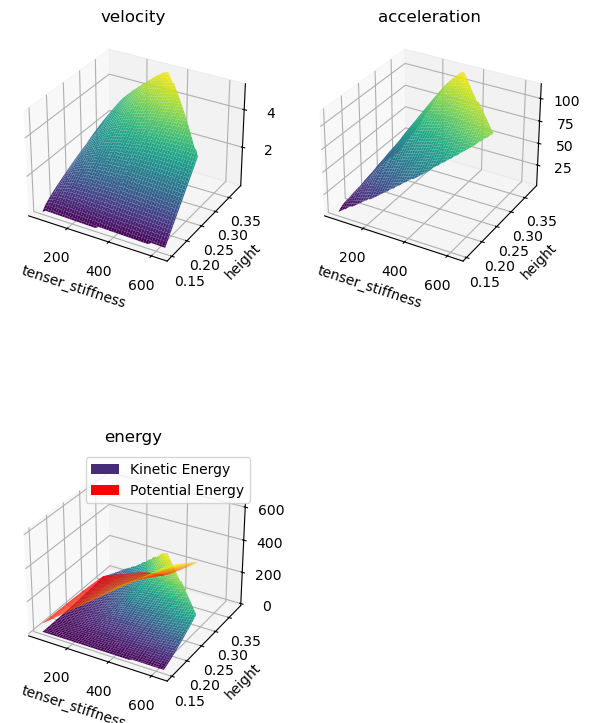

In [8]:
# 剔除None的数据
# 速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
z = [item for sublist in allData.all_cm_velocity_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='cubic')
fig = plt.figure(figsize=(7, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_stiffness')
ax1.set_ylabel('height')
ax1.set_title('velocity')
# 加速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_cm_acceleration_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='cubic')
ax1 = fig.add_subplot(222, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_stiffness')
ax1.set_ylabel('height')
ax1.set_title('acceleration')
# ax1.view_init(elev=30, azim=45)

# 动能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_stiffness_datas for item in sublist]
z = [item for sublist in allData.all_kinetic_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_kinetic, Y_kinetic = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_kinetic = griddata((x, y), z, (X, Y), method='cubic')

# 势能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_stiffness_datas for item in sublist]
z = [item for sublist in allData.all_potential_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_potential, Y_potential = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_potential = griddata((x, y), z, (X, Y), method='cubic')
ax1 = fig.add_subplot(223, projection='3d')
ax1.plot_surface(X_kinetic, Y_kinetic, Z_kinetic, cmap='viridis', label='Kinetic Energy')
ax1.plot_surface(X_potential, Y_potential, Z_potential, cmap='autumn', label='Potential Energy')
plt.legend()
ax1.set_xlabel('tenser_stiffness')
ax1.set_ylabel('height')
ax1.set_title('energy')
plt.tight_layout()
plt.show()

## 改变弹簧原长实验
弹簧刚度为100，原长从0.1提升到1


In [9]:
num_of_test = 20 # 试验次数

def task(queue, i):
    xml_path = "./xml/hopper1/scene.xml"
    sim = Hopper1(xml_path)
    sim.model.tendon_lengthspring[0] = [0.1 + i*0.05, 0.1 + i*0.05]
    print(f'第{i+1}次实验，弹簧原长为{sim.model.tendon_lengthspring[0, 0]}。\n')
    sim.is_render = False
    sim.is_plot_data = False
    sim.is_save_data = False
    sim.is_save_image = False
    sim.simend = 2.0
    sim.Hz = 30
    sim.reset()
    sim.simulate()
    for index, data in enumerate(sim.hopperdata.jump_height_datas):
        # 只采集离地前的数据，获取离地前的数据的在列表中的位置i
        if abs(data) >= 0.01:
            break
    queue.put((sim.hopperdata.time_datas[:index], sim.hopperdata.kinetic_energy_datas[:index],
               sim.hopperdata.potential_energy_datas[:index],sim.hopperdata.total_energy_datas[:index],
               sim.hopperdata.cm_pos_z_datas[:index], sim.hopperdata.cm_vel_z_datas[:index],
               sim.hopperdata.cm_acc_z_datas[:index], [sim.model.tendon_lengthspring[0, 0]]*index))

def main(allData):
    queue = multiprocessing.Queue()
    processes = []
    for i in range(num_of_test):
        p = multiprocessing.Process(target=task, args=(queue, i))
        processes.append(p)
        p.start()

    allData.all_time_datas, allData.all_kinetic_energy_datas, \
    allData.all_potential_energy_datas, allData.all_total_energy_datas, \
    allData.all_cm_height_datas, allData.all_cm_velocity_datas, \
    allData.all_cm_acceleration_datas, allData.all_tenser_length_datas = \
    zip(*[queue.get() for _ in range(num_of_test)])
    
    for p in processes:
        p.join()
        
if __name__ == "__main__":
    allData = AllData()
    main(allData)

第1次实验，弹簧原长为0.1。

第2次实验，弹簧原长为0.15000000000000002。

第3次实验，弹簧原长为0.2。

第4次实验，弹簧原长为0.25。

第5次实验，弹簧原长为0.30000000000000004。

第6次实验，弹簧原长为0.35。

第7次实验，弹簧原长为0.4。
第8次实验，弹簧原长为0.45000000000000007。


第9次实验，弹簧原长为0.5。

第10次实验，弹簧原长为0.55。

第11次实验，弹簧原长为0.6。

第12次实验，弹簧原长为0.65。
第13次实验，弹簧原长为0.7000000000000001。


第15次实验，弹簧原长为0.8。


第14次实验，弹簧原长为0.75。
第16次实验，弹簧原长为0.85。

第17次实验，弹簧原长为0.9。

第18次实验，弹簧原长为0.9500000000000001。

第19次实验，弹簧原长为1.0。

第20次实验，弹簧原长为1.05。



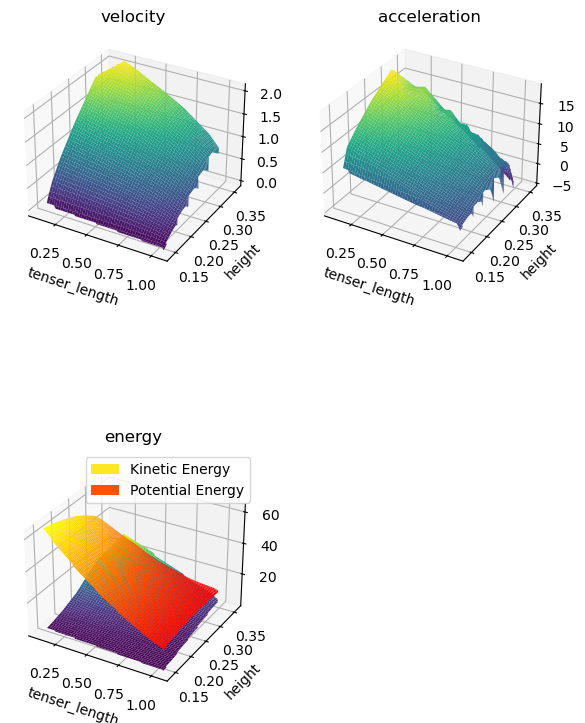

In [13]:
# 剔除None的数据
# 速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
z = [item for sublist in allData.all_cm_velocity_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear')
fig = plt.figure(figsize=(7, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('velocity')
# 加速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_cm_acceleration_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear')
ax1 = fig.add_subplot(222, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('acceleration')
# ax1.view_init(elev=30, azim=45)

# 动能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_kinetic_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_kinetic, Y_kinetic = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_kinetic = griddata((x, y), z, (X, Y), method='linear')

# 势能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_potential_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_potential, Y_potential = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_potential = griddata((x, y), z, (X, Y), method='cubic')
ax1 = fig.add_subplot(223, projection='3d')
ax1.plot_surface(X_kinetic, Y_kinetic, Z_kinetic, cmap='viridis', label='Kinetic Energy')
ax1.plot_surface(X_potential, Y_potential, Z_potential, cmap='autumn', label='Potential Energy')
plt.legend()
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('energy')
plt.tight_layout()
plt.show()

## 改变弹簧的布置，增加多一条竖直布置的弹簧
两个弹簧刚度不变，都为50，第一个弹簧原长不变，第二个弹簧原长从0.2变化到1


In [7]:
num_of_test = 20 # 试验次数

def task(queue, i):
    xml_path = "./xml/hopper1/hopper4.xml"
    sim = Hopper1(xml_path)
    sim.model.tendon_lengthspring[1] = [0.1 + i*0.05, 0.1 + i*0.05]
    print(f'第{i+1}次实验，弹簧原长为{sim.model.tendon_lengthspring[1, 0]}。\n')
    sim.is_render = False
    sim.is_plot_data = False
    sim.is_save_data = False
    sim.is_save_image = False
    sim.is_tqdm = False
    sim.simend = 2.0
    sim.Hz = 30
    sim.reset()
    sim.simulate()
    for index, data in enumerate(sim.hopperdata.jump_height_datas):
        # 只采集离地前的数据，获取离地前的数据的在列表中的位置i
        if abs(data) >= 0.01:
            break
    queue.put((sim.hopperdata.time_datas[:index], sim.hopperdata.kinetic_energy_datas[:index],
               sim.hopperdata.potential_energy_datas[:index],sim.hopperdata.total_energy_datas[:index],
               sim.hopperdata.cm_pos_z_datas[:index], sim.hopperdata.cm_vel_z_datas[:index],
               sim.hopperdata.cm_acc_z_datas[:index], [sim.model.tendon_lengthspring[1, 0]]*index))

def main(allData):
    queue = multiprocessing.Queue()
    processes = []
    for i in range(num_of_test):
        p = multiprocessing.Process(target=task, args=(queue, i))
        processes.append(p)
        p.start()

    allData.all_time_datas, allData.all_kinetic_energy_datas, \
    allData.all_potential_energy_datas, allData.all_total_energy_datas, \
    allData.all_cm_height_datas, allData.all_cm_velocity_datas, \
    allData.all_cm_acceleration_datas, allData.all_tenser_length_datas = \
    zip(*[queue.get() for _ in range(num_of_test)])
    
    for p in processes:
        p.join()
        
if __name__ == "__main__":
    allData = AllData()
    main(allData)

第1次实验，弹簧原长为0.1。

第2次实验，弹簧原长为0.15000000000000002。

第3次实验，弹簧原长为0.2。
第4次实验，弹簧原长为0.25。


第5次实验，弹簧原长为0.30000000000000004。
第6次实验，弹簧原长为0.35。


第7次实验，弹簧原长为0.4。

第8次实验，弹簧原长为0.45000000000000007。
第9次实验，弹簧原长为0.5。


第10次实验，弹簧原长为0.55。

第11次实验，弹簧原长为0.6。

第12次实验，弹簧原长为0.65。

第13次实验，弹簧原长为0.7000000000000001。

第14次实验，弹簧原长为0.75。

第15次实验，弹簧原长为0.8。

第16次实验，弹簧原长为0.85。

第17次实验，弹簧原长为0.9。

第18次实验，弹簧原长为0.9500000000000001。

第19次实验，弹簧原长为1.0。

第20次实验，弹簧原长为1.05。



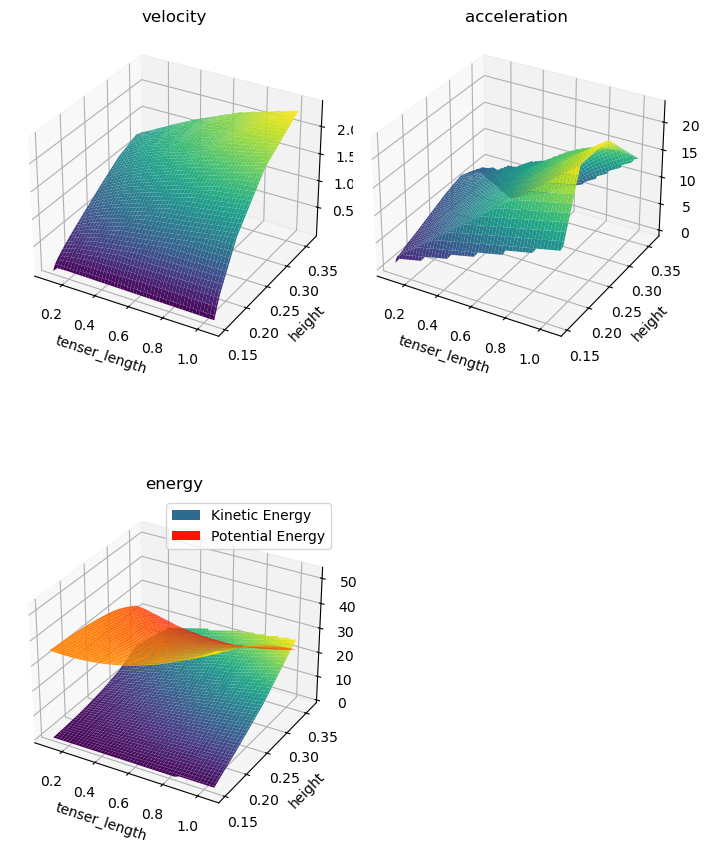

In [8]:
# 剔除None的数据
# 速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
z = [item for sublist in allData.all_cm_velocity_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear')
fig = plt.figure(figsize=(7, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('velocity')
# 加速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_cm_acceleration_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear')
ax1 = fig.add_subplot(222, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('acceleration')
# ax1.view_init(elev=30, azim=45)

# 动能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_kinetic_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_kinetic, Y_kinetic = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_kinetic = griddata((x, y), z, (X, Y), method='linear')

# 势能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_potential_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_potential, Y_potential = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_potential = griddata((x, y), z, (X, Y), method='cubic')
ax1 = fig.add_subplot(223, projection='3d')
ax1.plot_surface(X_kinetic, Y_kinetic, Z_kinetic, cmap='viridis', label='Kinetic Energy')
ax1.plot_surface(X_potential, Y_potential, Z_potential, cmap='autumn', label='Potential Energy')
plt.legend()
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('energy')
plt.tight_layout()
plt.show()

## 改变弹簧的布置，增加两条斜对称布置的弹簧
改变这两条弹簧的刚度

In [5]:
num_of_test = 20 # 试验次数

def task(queue, i):
    xml_path = "./xml/hopper1/hopper5.xml"
    sim = Hopper1(xml_path)
    sim.model.tendon_lengthspring[1] = [0.5 + i*0.05, 0.1 + i*0.05]
    sim.model.tendon_lengthspring[2] = [0.5 + i*0.05, 0.1 + i*0.05]
    print(f'第{i+1}次实验，弹簧原长为{sim.model.tendon_lengthspring[1, 0]}。\n')
    sim.is_render = False
    sim.is_plot_data = False
    sim.is_save_data = False
    sim.is_save_image = False
    # sim.is_tqdm = False
    sim.simend = 2.0
    sim.Hz = 30
    sim.reset()
    sim.simulate()
    for index, data in enumerate(sim.hopperdata.jump_height_datas):
        # 只采集离地前的数据，获取离地前的数据的在列表中的位置i
        if abs(data) >= 0.01:
            break
    queue.put((sim.hopperdata.time_datas[:index], sim.hopperdata.kinetic_energy_datas[:index],
               sim.hopperdata.potential_energy_datas[:index],sim.hopperdata.total_energy_datas[:index],
               sim.hopperdata.cm_pos_z_datas[:index], sim.hopperdata.cm_vel_z_datas[:index],
               sim.hopperdata.cm_acc_z_datas[:index], [sim.model.tendon_lengthspring[1, 0]]*index))

def main(allData):
    queue = multiprocessing.Queue()
    processes = []
    for i in range(num_of_test):
        p = multiprocessing.Process(target=task, args=(queue, i))
        processes.append(p)
        p.start()

    allData.all_time_datas, allData.all_kinetic_energy_datas, \
    allData.all_potential_energy_datas, allData.all_total_energy_datas, \
    allData.all_cm_height_datas, allData.all_cm_velocity_datas, \
    allData.all_cm_acceleration_datas, allData.all_tenser_length_datas = \
    zip(*[queue.get() for _ in range(num_of_test)])
    
    for p in processes:
        p.join()
        
if __name__ == "__main__":
    allData = AllData()
    main(allData)

第1次实验，弹簧原长为0.5。

第2次实验，弹簧原长为0.55。


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

第3次实验，弹簧原长为0.6。

第4次实验，弹簧原长为0.65。



  0%|          | 0/100 [00:00<?, ?it/s]

第5次实验，弹簧原长为0.7。



  0%|          | 0/100 [00:00<?, ?it/s]

第6次实验，弹簧原长为0.75。
第7次实验，弹簧原长为0.8。


第8次实验，弹簧原长为0.8500000000000001。



  0%|          | 0/100 [00:00<?, ?it/s]

第9次实验，弹簧原长为0.9。

第10次实验，弹簧原长为0.95。



  0%|          | 0/100 [00:00<?, ?it/s]

第11次实验，弹簧原长为1.0。
第12次实验，弹簧原长为1.05。


第13次实验，弹簧原长为1.1。


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

第14次实验，弹簧原长为1.15。
第15次实验，弹簧原长为1.2000000000000002。




  0%|          | 0/100 [00:00<?, ?it/s]

第16次实验，弹簧原长为1.25。


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

第17次实验，弹簧原长为1.3。



  0%|          | 0/100 [00:00<?, ?it/s]

第18次实验，弹簧原长为1.35。
第19次实验，弹簧原长为1.4。




  0%|          | 0/100 [00:00<?, ?it/s]

第20次实验，弹簧原长为1.4500000000000002。



100%|██████████| 100/100 [00:01<00:00, 64.10it/s]


In [ ]:
# 画图
# 剔除None的数据
# 速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
z = [item for sublist in allData.all_cm_velocity_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear')
fig = plt.figure(figsize=(7, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('velocity')
# 加速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_cm_acceleration_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear')
ax1 = fig.add_subplot(222, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('acceleration')
# ax1.view_init(elev=30, azim=45)

# 动能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_kinetic_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_kinetic, Y_kinetic = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_kinetic = griddata((x, y), z, (X, Y), method='linear')

# 势能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_potential_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_potential, Y_potential = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_potential = griddata((x, y), z, (X, Y), method='cubic')
ax1 = fig.add_subplot(223, projection='3d')
ax1.plot_surface(X_kinetic, Y_kinetic, Z_kinetic, cmap='viridis', label='Kinetic Energy')
ax1.plot_surface(X_potential, Y_potential, Z_potential, cmap='autumn', label='Potential Energy')
plt.legend()
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('energy')
plt.tight_layout()
plt.show()

# 参数综合
弹簧长度 弹簧刚度 弹簧构型 

只选取最高点的速度 加速度 能量

In [56]:
# 改变弹簧刚度
num_of_test = 60 # 试验次数

def task(queue, i):
    xml_path = "./xml/hopper1/scene.xml"
    sim = Hopper1(xml_path)
    sim.model.tendon_stiffness[0] = 50 + i * 15
    print(f'第{i+1}次实验，弹簧刚度为{sim.model.tendon_stiffness[0]}。\n')
    sim.is_render = False
    sim.is_plot_data = False
    sim.is_save_data = False
    sim.is_save_image = False
    sim.is_tqdm = False
    sim.simend = 2.0
    sim.Hz = 30
    sim.reset()
    sim.simulate()
    for index, data in enumerate(sim.hopperdata.jump_height_datas):
        # 只采集最高点的数据，获取离地前的数据的在列表中的位置i
        if abs(data) >= 0.01:
            break
    queue.put((sim.hopperdata.time_datas[index], sim.hopperdata.kinetic_energy_datas[index],
               sim.hopperdata.potential_energy_datas[index],sim.hopperdata.total_energy_datas[index],
               sim.hopperdata.cm_pos_z_datas[index], sim.hopperdata.cm_vel_z_datas[index],
               sim.hopperdata.cm_acc_z_datas[index], [sim.model.tendon_stiffness[0]]))

def main(allData):
    queue = multiprocessing.Queue()
    processes = []
    for i in range(num_of_test):
        p = multiprocessing.Process(target=task, args=(queue, i))
        processes.append(p)
        p.start()

    allData.all_time_datas, allData.all_kinetic_energy_datas, \
    allData.all_potential_energy_datas, allData.all_total_energy_datas, \
    allData.all_cm_height_datas, allData.all_cm_velocity_datas, \
    allData.all_cm_acceleration_datas, allData.all_tenser_stiffness_datas = \
    zip(*[queue.get() for _ in range(num_of_test)])
    
    for p in processes:
        p.join()
        
if __name__ == "__main__":
    allData = AllData()
    main(allData)

第1次实验，弹簧刚度为50.0。

第2次实验，弹簧刚度为65.0。

第3次实验，弹簧刚度为80.0。

第4次实验，弹簧刚度为95.0。

第5次实验，弹簧刚度为110.0。

第6次实验，弹簧刚度为125.0。

第7次实验，弹簧刚度为140.0。

第8次实验，弹簧刚度为155.0。
第9次实验，弹簧刚度为170.0。


第10次实验，弹簧刚度为185.0。

第11次实验，弹簧刚度为200.0。
第12次实验，弹簧刚度为215.0。


第13次实验，弹簧刚度为230.0。

第14次实验，弹簧刚度为245.0。
第15次实验，弹簧刚度为260.0。


第16次实验，弹簧刚度为275.0。

第17次实验，弹簧刚度为290.0。

第18次实验，弹簧刚度为305.0。

第19次实验，弹簧刚度为320.0。

第20次实验，弹簧刚度为335.0。
第21次实验，弹簧刚度为350.0。


第22次实验，弹簧刚度为365.0。

第23次实验，弹簧刚度为380.0。

第25次实验，弹簧刚度为410.0。
第26次实验，弹簧刚度为425.0。
第24次实验，弹簧刚度为395.0。
第27次实验，弹簧刚度为440.0。


第29次实验，弹簧刚度为470.0。
第28次实验，弹簧刚度为455.0。




第30次实验，弹簧刚度为485.0。
第32次实验，弹簧刚度为515.0。

第31次实验，弹簧刚度为500.0。

第34次实验，弹簧刚度为545.0。
第33次实验，弹簧刚度为530.0。


第35次实验，弹簧刚度为560.0。
第38次实验，弹簧刚度为605.0。
第36次实验，弹簧刚度为575.0。

第37次实验，弹簧刚度为590.0。


第39次实验，弹簧刚度为620.0。
第40次实验，弹簧刚度为635.0。




第46次实验，弹簧刚度为725.0。
第43次实验，弹簧刚度为680.0。
第44次实验，弹簧刚度为695.0。
第41次实验，弹簧刚度为650.0。


第42次实验，弹簧刚度为665.0。

第45次实验，弹簧刚度为710.0。

第48次实验，弹簧刚度为755.0。

第47次实验，弹簧刚度为740.0。



第49次实验，弹簧刚度为770.0。
第50次实验，弹簧刚度为785.0。
第52次实验，弹簧刚度为815

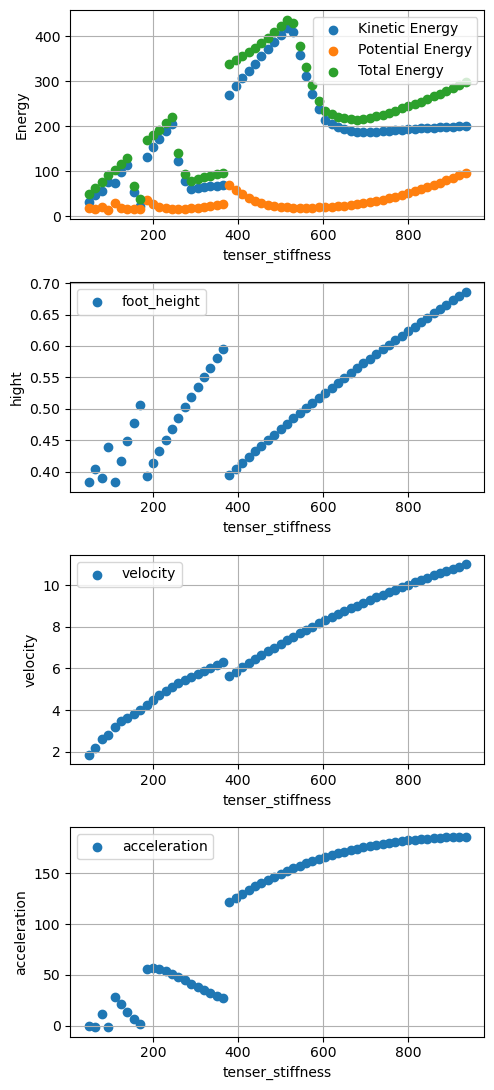

In [57]:
row = 4
column = 1

plt.figure(figsize=(5, 11))
plt.tight_layout()
plt.subplot(row, column, 1)
plt.grid(True)
plt.scatter(allData.all_tenser_stiffness_datas, allData.all_kinetic_energy_datas, label='Kinetic Energy')
plt.scatter(allData.all_tenser_stiffness_datas, allData.all_potential_energy_datas, label='Potential Energy')
plt.scatter(allData.all_tenser_stiffness_datas, allData.all_total_energy_datas, label='Total Energy')
plt.xlabel('tenser_stiffness')
plt.ylabel('Energy')
plt.legend()

plt.subplot(row, column, 2)
plt.grid(True)
plt.scatter(allData.all_tenser_stiffness_datas, allData.all_cm_height_datas, label='foot_height')
plt.xlabel('tenser_stiffness')
plt.ylabel('hight')
plt.legend()

plt.subplot(row, column, 3)
plt.grid(True)
plt.scatter(allData.all_tenser_stiffness_datas, allData.all_cm_velocity_datas, label='velocity')
plt.xlabel('tenser_stiffness')
plt.ylabel('velocity')
plt.legend()

plt.subplot(row, column, 4)
plt.grid(True)
plt.scatter(allData.all_tenser_stiffness_datas, allData.all_cm_acceleration_datas, label='acceleration')
plt.xlabel('tenser_stiffness')
plt.ylabel('acceleration')
plt.legend()
plt.tight_layout()


同时改变弹簧的原长和刚度

In [60]:
num_of_test_stiffness = 30 # 试验次数
num_of_test_length = 20


def task(queue, i, j):
    xml_path = "./xml/hopper1/scene.xml"
    sim = Hopper1(xml_path)
    sim.model.tendon_stiffness[0] = 50 + i * 20
    sim.model.tendon_lengthspring[0] = [0.1 + j*0.05, 0.1 + j*0.05]
    print(f'第{i*10+j}次实验，弹簧原长为{sim.model.tendon_lengthspring[0, 0]}\n \
          弹簧刚度为{sim.model.tendon_stiffness[0]}\n')
    sim.is_render = False
    sim.is_plot_data = False
    sim.is_save_data = False
    sim.is_save_image = False
    sim.is_tqdm = False
    sim.simend = 2.0
    sim.Hz = 30
    sim.reset()
    sim.simulate()
    for index, data in enumerate(sim.hopperdata.jump_height_datas):
        # 只采集最高点的数据，获取离地前的数据的在列表中的位置i
        if abs(data) >= 0.01:
            break
    queue.put((sim.hopperdata.time_datas[index], sim.hopperdata.kinetic_energy_datas[index],
               sim.hopperdata.potential_energy_datas[index],sim.hopperdata.total_energy_datas[index],
               sim.hopperdata.cm_pos_z_datas[index], sim.hopperdata.cm_vel_z_datas[index],
               sim.hopperdata.cm_acc_z_datas[index], [sim.model.tendon_stiffness[0]], [sim.model.tendon_lengthspring[0, 0]]))

def main(allData:AllData):
    queue = multiprocessing.Queue()
    processes = []
    for i in range(num_of_test_stiffness):
        for j in range(num_of_test_length):
            p = multiprocessing.Process(target=task, args=(queue, i, j))
            processes.append(p)
            p.start()

    allData.all_time_datas, allData.all_kinetic_energy_datas, \
    allData.all_potential_energy_datas, allData.all_total_energy_datas, \
    allData.all_cm_height_datas, allData.all_cm_velocity_datas, \
    allData.all_cm_acceleration_datas, allData.all_tenser_stiffness_datas, allData.all_tenser_length_datas = \
    zip(*[queue.get() for _ in range(num_of_test_stiffness*num_of_test_length)])
    
    for p in processes:
        p.join()
        
if __name__ == "__main__":
    allData = AllData()
    main(allData)

  0%|          | 0/6 [00:00<?, ?it/s]

第1次实验：
第2次实验：
第3次实验：
第4次实验：
第5次实验：
弹簧原长为0.1
           弹簧刚度为50.0

第6次实验：
弹簧原长为0.15000000000000002
           弹簧刚度为50.0

弹簧原长为0.1
           弹簧刚度为70.0

弹簧原长为0.15000000000000002
           弹簧刚度为70.0

弹簧原长为0.1
           弹簧刚度为90.0

弹簧原长为0.15000000000000002
           弹簧刚度为90.0



In [28]:
print(allData.all_cm_acceleration_datas)

(-9.520759871257503, -0.9885238358941957, 4.8517732662162, -2.5673903589534404, 2.405546148641765, -2.2504929876432995, -9.516089246723567, 2.0105252659911526, 4.098016879595685, -9.090077982570737, 5.454171602554892, -4.477171118664387, 9.000226790179303, 0.884789562598859, -3.8946281548022927, -4.4502200480634375, -6.488627452987019, -8.61852131425638, 8.457664776089795, 25.86003870596911, -4.418906353680573, -6.071242293196199, 0.34913136799219446, 8.255701802228533, 24.253611982784903, 2.748171241929507, -1.0801699996651053, 5.978385770308832, -3.314620886111939, -6.2068749564980745, -8.972465840635033, -6.05373156380628, -5.983582012494489, -9.590309118891064, 11.460829265553485, 54.480384702675124, 19.140579059646765, 11.505891150073214, 1.0792906377705587, 23.43892110739077, 2.0280359813348183, 9.204219097940381, 3.765143673038141, 7.225486280780919, -7.940751216794244, -0.7853812699143242, 8.726884413037883, -8.99233239659557, -9.896205557150994, 9.074719037074093, -9.812064571

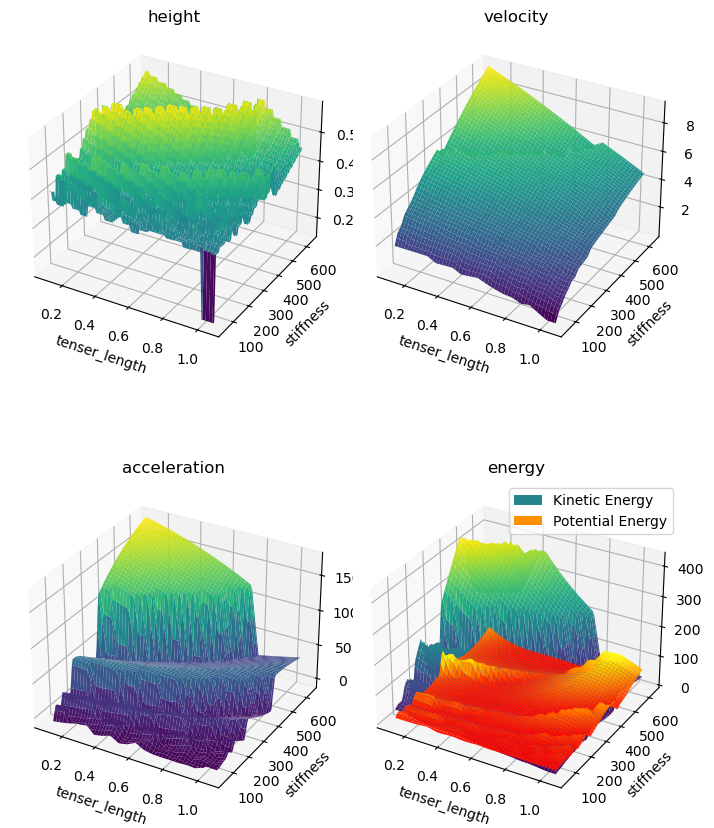

In [42]:
fig = plt.figure(figsize=(7, 10))

y = allData.all_tenser_stiffness_datas
z = allData.all_cm_height_datas
x = allData.all_tenser_length_datas

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='nearest')

ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('stiffness')
ax1.set_title('height')


y = allData.all_tenser_stiffness_datas
z = allData.all_cm_velocity_datas
x = allData.all_tenser_length_datas

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear')

ax1 = fig.add_subplot(222, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('stiffness')
ax1.set_title('velocity')

# 加速度
y = allData.all_tenser_stiffness_datas
z = allData.all_cm_acceleration_datas
x = allData.all_tenser_length_datas

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear')
ax1 = fig.add_subplot(223, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('stiffness')
ax1.set_title('acceleration')
# ax1.view_init(elev=30, azim=45)

# 动能
y = allData.all_tenser_stiffness_datas
z = allData.all_kinetic_energy_datas
x = allData.all_tenser_length_datas

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_kinetic, Y_kinetic = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_kinetic = griddata((x, y), z, (X, Y), method='linear')

# 势能
y = allData.all_tenser_stiffness_datas
z = allData.all_potential_energy_datas
x = allData.all_tenser_length_datas

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_potential, Y_potential = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_potential = griddata((x, y), z, (X, Y), method='cubic')
ax1 = fig.add_subplot(224, projection='3d')
ax1.plot_surface(X_kinetic, Y_kinetic, Z_kinetic, cmap='viridis', label='Kinetic Energy')
ax1.plot_surface(X_potential, Y_potential, Z_potential, cmap='autumn', label='Potential Energy')
plt.legend()
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('stiffness')
ax1.set_title('energy')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'hight')

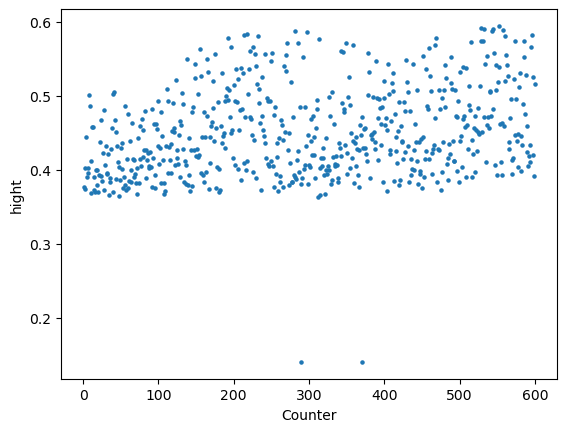

In [53]:
plt.figure()
n = len(allData.all_cm_height_datas)
increasing_list = [i+1 for i in range(n)]
height_list = list(allData.all_cm_height_datas)
plt.scatter(increasing_list, height_list, s=5)
plt.xlabel('Counter')
plt.ylabel('hight')


增加一条竖直的弹簧，同时改变两条弹簧的刚度

In [69]:
# 改变弹簧刚度
num_of_test = 60 # 试验次数

def task(queue, i):
    xml_path = "./xml/hopper1/hopper4.xml"
    sim = Hopper1(xml_path)
    sim.model.tendon_lengthspring[1] = [0.1 + i*0.05, 0.1 + i*0.05]
    # sim.model.tendon_stiffness[0] = 50 + i * 15
    print(f'第{i+1}次实验，弹簧刚度为{sim.model.tendon_stiffness[0]}。\n')
    sim.is_render = False
    sim.is_plot_data = False
    sim.is_save_data = False
    sim.is_save_image = False
    sim.is_tqdm = False
    sim.simend = 2.0
    sim.Hz = 30
    sim.reset()
    sim.simulate()
    for index, data in enumerate(sim.hopperdata.jump_height_datas):
        # 只采集最高点的数据，获取离地前的数据的在列表中的位置i
        if abs(data) >= 0.01:
            break
    queue.put((sim.hopperdata.time_datas[index], sim.hopperdata.kinetic_energy_datas[index],
               sim.hopperdata.potential_energy_datas[index],sim.hopperdata.total_energy_datas[index],
               sim.hopperdata.cm_pos_z_datas[index], sim.hopperdata.cm_vel_z_datas[index],
               sim.hopperdata.cm_acc_z_datas[index], sim.model.tendon_lengthspring[1][0]))

def main(allData:AllData):
    queue = multiprocessing.Queue()
    processes = []
    for i in range(num_of_test):
        p = multiprocessing.Process(target=task, args=(queue, i))
        processes.append(p)
        p.start()

    allData.all_time_datas, allData.all_kinetic_energy_datas, \
    allData.all_potential_energy_datas, allData.all_total_energy_datas, \
    allData.all_cm_height_datas, allData.all_cm_velocity_datas, \
    allData.all_cm_acceleration_datas, allData.all_tenser_length_datas = \
    zip(*[queue.get() for _ in range(num_of_test)])
    
    for p in processes:
        p.join()
        
if __name__ == "__main__":
    allData = AllData()
    main(allData)

第1次实验，弹簧刚度为50.0。

第2次实验，弹簧刚度为50.0。

第3次实验，弹簧刚度为50.0。

第4次实验，弹簧刚度为50.0。

第5次实验，弹簧刚度为50.0。

第6次实验，弹簧刚度为50.0。

第7次实验，弹簧刚度为50.0。

第8次实验，弹簧刚度为50.0。

第9次实验，弹簧刚度为50.0。

第10次实验，弹簧刚度为50.0。

第11次实验，弹簧刚度为50.0。

第12次实验，弹簧刚度为50.0。

第13次实验，弹簧刚度为50.0。

第14次实验，弹簧刚度为50.0。

第15次实验，弹簧刚度为50.0。

第16次实验，弹簧刚度为50.0。
第17次实验，弹簧刚度为50.0。


第19次实验，弹簧刚度为50.0。
第18次实验，弹簧刚度为50.0。


第20次实验，弹簧刚度为50.0。

第21次实验，弹簧刚度为50.0。

第22次实验，弹簧刚度为50.0。

第23次实验，弹簧刚度为50.0。
第24次实验，弹簧刚度为50.0。


第25次实验，弹簧刚度为50.0。

第27次实验，弹簧刚度为50.0。

第26次实验，弹簧刚度为50.0。

第28次实验，弹簧刚度为50.0。
第29次实验，弹簧刚度为50.0。

第31次实验，弹簧刚度为50.0。

第33次实验，弹簧刚度为50.0。
第30次实验，弹簧刚度为50.0。

第32次实验，弹簧刚度为50.0。
第36次实验，弹簧刚度为50.0。
第35次实验，弹簧刚度为50.0。


第34次实验，弹簧刚度为50.0。



第37次实验，弹簧刚度为50.0。

第40次实验，弹簧刚度为50.0。
第41次实验，弹簧刚度为50.0。

第38次实验，弹簧刚度为50.0。
第39次实验，弹簧刚度为50.0。


第44次实验，弹簧刚度为50.0。
第42次实验，弹簧刚度为50.0。

第43次实验，弹簧刚度为50.0。




第47次实验，弹簧刚度为50.0。
第45次实验，弹簧刚度为50.0。
第46次实验，弹簧刚度为50.0。


第49次实验，弹簧刚度为50.0。

第48次实验，弹簧刚度为50.0。
第50次实验，弹簧刚度为50.0。


第52次实验，弹簧刚度为50.0。


第51次实验，弹簧刚度为50.0。
第54次实验，弹簧刚度为50.0。
第53次

In [70]:
print(allData.all_kinetic_energy_datas)

(56.431778409116234, 36.37986399737247, 32.000661996990196, 21.74773686957778, 41.47179086269351, 61.79732259663362, 34.76216460279058, 28.443632789286525, 30.002566872270588, 62.80567844577173, 59.29187548666643, 31.927627585890352, 60.721739988739024, 41.60595900857935, 41.20425129199099, 55.28027700311558, 41.61056131763101, 63.11379761475902, 27.056932634876496, 39.12355381081141, 24.346021236861336, 22.565370081362023, 21.598808168408258, 37.65147074493176, 38.927630515889255, 31.57340392565054, 40.58593978453733, 27.177836382237665, 39.863292743660864, 31.088807366843906, 58.43629241647132, 16.058732429378225, 61.30215325494012, 41.443333476415404, 38.41406434928891, 26.20175847296143, 26.399718940469413, 63.16099301232855, 52.680695079437065, 57.483513342708406, 22.284644657204186, 17.593898705395716, 17.357272341922624, 62.99402052391524, 40.33955652125285, 39.769217577938036, 40.82225538478146, 41.10807973468919, 30.988665004165906, 36.84555614173688, 24.457684106222466, 31.73

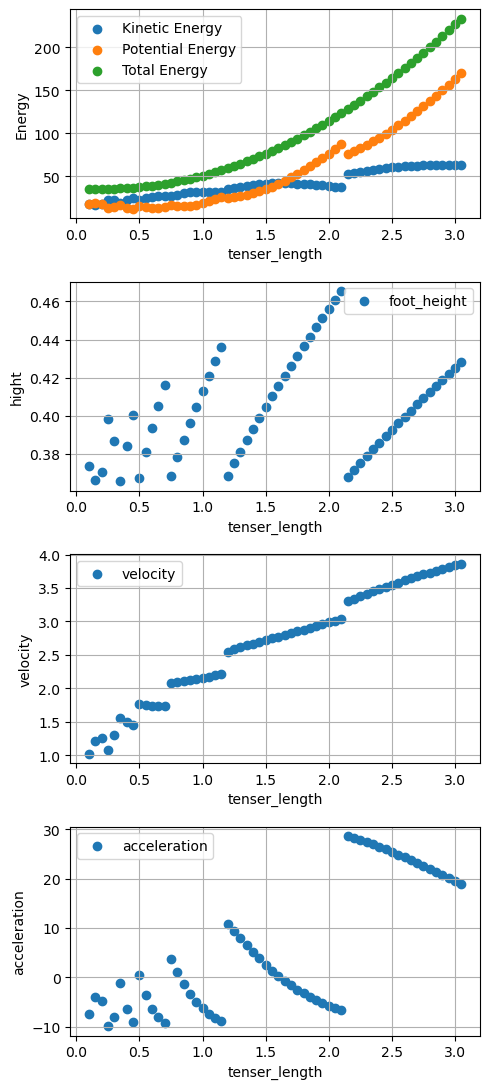

In [72]:
row = 4
column = 1

plt.figure(figsize=(5, 11))
plt.tight_layout()
plt.subplot(row, column, 1)
plt.grid(True)
plt.scatter(allData.all_tenser_length_datas, allData.all_kinetic_energy_datas, label='Kinetic Energy')
plt.scatter(allData.all_tenser_length_datas, allData.all_potential_energy_datas, label='Potential Energy')
plt.scatter(allData.all_tenser_length_datas, allData.all_total_energy_datas, label='Total Energy')
plt.xlabel('tenser_length')
plt.ylabel('Energy')
plt.legend()

plt.subplot(row, column, 2)
plt.grid(True)
plt.scatter(allData.all_tenser_length_datas, allData.all_cm_height_datas, label='foot_height')
plt.xlabel('tenser_length')
plt.ylabel('hight')
plt.legend()

plt.subplot(row, column, 3)
plt.grid(True)
plt.scatter(allData.all_tenser_length_datas, allData.all_cm_velocity_datas, label='velocity')
plt.xlabel('tenser_length')
plt.ylabel('velocity')
plt.legend()

plt.subplot(row, column, 4)
plt.grid(True)
plt.scatter(allData.all_tenser_length_datas, allData.all_cm_acceleration_datas, label='acceleration')
plt.xlabel('tenser_length')
plt.ylabel('acceleration')
plt.legend()
plt.tight_layout()
